![](mldd_diagram_lab5.png)

# Introduction to (Deep) Generative Models

Generative models are unsupervised ML algorithms, which means that the input data (usually) does not contain labels. Based on the input representation, generative models learn data distribution, which enables generation of novel examples that are similar to those observed in the training.

A typical application of generative models is image, text, or compound generation. Several classes of generative models based on neural networks are presented below.

1. **Autoencoder** - a model that consists of two networks, an encoder and decoder. The encoder takes the input representation of data and transforms it into a lower-dimensional latent representation (numerical vector). The decoder uses encoded vectors to reconstruct the initial data representation. We can write that $x'=D(E(x))$, and the optimization target is to minimize the difference between the input object $x$ and the reconstructed object $x'$, so the loss function can be $\mathcal{L}=\|x-x' \|_2$ in the case of simple numerical objects as for example images. To make this model generative, the latent space is additionally constrained to follow the Gaussian distribution, i.e. $\mathcal{L}=\|x-x' \|_2 + \mathcal{L}_{normal}(E(x))$. Then, if we sample a latent vector $z\sim \mathcal{N}(0, 1)$ and transform it using the decoder $x'=D(z)$, we will obtain a new generated object.
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png)
2. **Recurrent neural network (autoregressive modeling)** - a type of neural network in which a partial output is used as the input to the next segment of the network. Recurrent neural networks generate objects by growing object fragments, e.g. texts can be generated word-by-word, and molecules can be created by adding atoms iteratively. The intermediate steps of the generative process are used as the input to the model which decides about the next generation step.
![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Gated_Recurrent_Unit.svg)

# How generative models are used to design new drugs

There are two ways in which generative models can be applied in drug design. We can generate compounds from scratch, and we call this process *de novo* drug design. The other application is optimization of existing molecules, e.g. during the **lead optimization** stage of drug discovery where our promising compound (so called lead) is modified to increase the activity or optimize other molecular properties (ADMET).

Two types of generators can be used to invent new compounds: those based on **SMILES** and those based on **molecular graphs**. We can generate a SMILES sequence, but this representation is prone to produce invalid molecules (SMILES has a strict grammar), on top of other shortcomings discussed when introducing SMILES predictive models. Graph generation seems more reasonable, but this approach also has some downsides:

1. Sequential atom-by-atom generation leads to **incorrect intermediate states**. For example, to generate a ring, we need to first generate a long chain of atoms that is closed in the last step. One possible solution to this problem is fragment-based design where we expand molecules by attaching whole structures (e.g. rings) instead of single atoms.
2. Molecular graphs are **discrete structures** meaning that atoms and bonds are defined by binary features. We cannot generate partial bonds or mixed atom symbols. Hence, the continuous output of a neural network needs to be converted to a discrete structure, e.g. an adjacency matrix should be rounded to contain only zeros and ones. By discretizing outputs, we lose differentiability of the network, so we can apply the loss function only to the incorrect continuous representation of the molecule before rounding all the numbers. There are some solutions to this problem, e.g. Gumbel Softmax is a technique that allows to preserve the differentiability of the rounding operation. We can also use reinforcement learning that does not require the network to be differentiable (the gradients are calculated in a different way, based on a reward function).

Another factor we need to consider when designing drugs is optimization of molecular properties. Not only do we want to generate correct compounds, but also we need these molecules to be synthesizable and possess all the desirable properties. Tp that end, additional learning terms are often included in the generative process.

# SMILES-based generative model: ReLeaSE

Code repo: https://github.com/isayev/ReLeaSE ([Paper](https://www.science.org/doi/epdf/10.1126/sciadv.aap7885))

**TL;DR**

In this paper, a SMILES generator is implemented. Because SMILES follows certain grammar rules, and it is "almost" a context-free grammar, for which there exists a pushdown automaton that accepts this grammar. A stack is needed for the model to remember, e.g., opening of parentheses that denote atom branches or numbers that denote ring closures. By adding a stack to a recurrent neural network (e.g. GRU), we can improve the validity of generated SMILES strings. Additionally, molecular properties of the generated compounds can be optimized by employing a predictive model that calculates the value of a reward function. The reward is calculated when the full SMILES string is generated. Model parameters are corrected using reinforcement learning, and more precisely the REINFORCE algorithm.

In [25]:
!git clone https://github.com/isayev/ReLeaSE.git

In [2]:
import sys
sys.path.append('ReLeaSE/release')

In [3]:
import torch
from rdkit import Chem

In [4]:
from stackRNN import StackAugmentedRNN
from data import GeneratorData

use_cuda = False

In [26]:
hidden_size = 50
stack_width = 50
stack_depth = 10
lr = 0.001
optimizer_instance = torch.optim.Adadelta
layer_type = 'GRU'

gen_data_path = 'ReLeaSE/data/logP_labels.csv'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[1], keep_header=False)

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters,
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters,
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=True,
                                 has_stack=True,
                                 stack_width=stack_width,
                                 stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 optimizer_instance=optimizer_instance,
                                 lr=lr)
if use_cuda:
    my_generator = my_generator.cuda()

losses = my_generator.fit(gen_data, 1000)

my_generator.evaluate(gen_data)

In [8]:
gen_data_path = 'ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

model = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=1500,
                                     output_size=gen_data.n_characters, 
                                     layer_type='GRU',
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=1500, stack_depth=10, 
                                     use_cuda=use_cuda)

if use_cuda:
    model.load_model('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn')
else:
    weights = torch.load('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn', map_location=torch.device('cpu'))
    model.load_state_dict(weights)

Random Smile:  Fc1ccc2ncnc(NN3CCCC3=O)c2c1


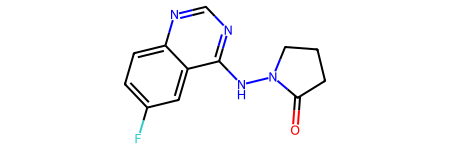

In [18]:
smiles = model.evaluate(gen_data)[1:-1]

print('Random Smile: ', smiles)
mol = Chem.MolFromSmiles(smiles)
if mol:
    display(mol)
else:
    print('Invalid SMILES!')

# Graph-based generative model: JT-VAE

Code repo: https://github.com/Bibyutatsu/FastJTNNpy3 ([Paper](https://arxiv.org/pdf/1802.04364.pdf))

**TL;DR**

JT-VAE is an autoencoder working on molecular graphs. To facilitate compound generation, structural formulas are converted to so-called junction trees, in which rings are transformed into single nodes. This way, instead of a graph, we obtain a tree structure that can be decoded to a compound. The graph encoder is a graph neural network (MPNN), and the tree encoder is a similar architecture, but only passes messages from the root to the leaves. The tree decoder is a recurrent neural network (GRU) that builds a tree in the DFS order. The graph decoder is used to correctly connect atoms after decoding tree nodes - rings have multiple possible attachment points. To optimize molecular properties, we can use Bayesian search of the encoded latent space.

In [27]:
!git clone https://github.com/Bibyutatsu/FastJTNNpy3.git

import sys
use_cuda = False
sys.path.append('FastJTNNpy3')

In [5]:
import fnmatch, os

if not use_cuda:
    for path, dirs, files in os.walk(os.path.abspath("FastJTNNpy3")):
        for filename in fnmatch.filter(files, "*.py"):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace(".cuda()", "")
            with open(filepath, "w") as f:
                f.write(s)

In [28]:
from rdkit import Chem
import torch

from fast_jtnn import *
import rdkit

def load_model(vocab, model_path, hidden_size=450, latent_size=56, depthT=20, depthG=3, use_cuda=True):
    vocab = [x.strip("\r\n ") for x in open(vocab)] 
    vocab = Vocab(vocab)

    model = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
    if use_cuda:
        dict_buffer = torch.load(model_path)
    else:
        dict_buffer = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(dict_buffer)
    if use_cuda:
        model = model.cuda()

    torch.manual_seed(0)
    return model

model = load_model('FastJTNNpy3/data/vocab.txt', 'FastJTNNpy3/fast_molvae/vae_model/model.epoch-19', use_cuda=use_cuda)

[11:10:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:10:55] Explicit valence for atom # 1 C, 5, is greater than permitted


Random Smile:  CON1C=CC=CC1C(=O)Nc1ccccc1[N+](=O)[O-]


[11:10:56] Explicit valence for atom # 1 C, 5, is greater than permitted


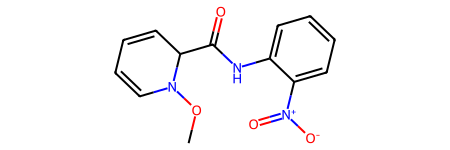

In [24]:
z = torch.randn(1, 56//2)
smiles = model.decode(z, z, False)
print('Random Smile: ', smiles)
Chem.MolFromSmiles(smiles)

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile2.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Ester:</strong> Evaluating generative models for small molecules presents unique challenges due to the complexity and diversity of chemical space. Some special problems that emerge include:

<ol>
    <li>Chemical validity: Ensuring that generated molecules adhere to the rules of chemistry is crucial. This includes checking for correct valency, bond types, and absence of impossible chemical structures.</li>
    <li>Drug-likeness: Generated molecules should possess properties that make them suitable candidates for drug development, such as favorable pharmacokinetics and absence of toxic functional groups.</li>
    <li>Diversity and novelty: It's important for generative models to produce diverse and novel molecules, rather than generating duplicates or minor variations of existing compounds.</li>
    <li>Property optimization: If the generative model is aimed at optimizing specific properties (e.g., potency, solubility), evaluating how well it achieves this goal is essential.</li>
    <li>Data efficiency: Generative models for small molecules should be able to generate meaningful molecules even when trained on limited data, as chemical datasets are often smaller than those in other domains.</li>
</ol>
</p>
    </div>
</div>

---

# REINVENT

Code repo: https://github.com/MarcusOlivecrona/REINVENT ([Paper](https://arxiv.org/pdf/1704.07555.pdf))

**TL;DR**

The REINVENT model is a recurrent neural network that generates SMILES strings. The model is trained in two steps. The first step is the training of a prior network that learns to generate molecules that are similar to the compounds in the ChEMBL dataset. The next step is the optimization of molecular properties using reinforcement learning.

**Exercise:** Use the REINVENT model to optimize LogP of the generated compounds. The expected result is a shift of LogP distribution in the generated sample.

In [18]:
# Code adapted from https://github.com/MarcusOlivecrona/REINVENT shared under the MIT license
# Small modifications made to make it compatible with the new PyTorch version

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import Variable


class MultiGRU(nn.Module):
    """ Implements a three layer GRU cell including an embedding layer
       and an output linear layer back to the size of the vocabulary"""
    def __init__(self, voc_size):
        super(MultiGRU, self).__init__()
        self.embedding = nn.Embedding(voc_size, 128)
        self.gru_1 = nn.GRUCell(128, 512)
        self.gru_2 = nn.GRUCell(512, 512)
        self.gru_3 = nn.GRUCell(512, 512)
        self.linear = nn.Linear(512, voc_size)

    def forward(self, x, h):
        x = self.embedding(x)
        h_out = Variable(torch.zeros(h.size()))
        x = h_out[0] = self.gru_1(x, h[0])
        x = h_out[1] = self.gru_2(x, h[1])
        x = h_out[2] = self.gru_3(x, h[2])
        x = self.linear(x)
        return x, h_out

    def init_h(self, batch_size):
        # Initial cell state is zero
        return Variable(torch.zeros(3, batch_size, 512))

class RNN():
    """Implements the Prior and Agent RNN. Needs a Vocabulary instance in
    order to determine size of the vocabulary and index of the END token"""
    def __init__(self, voc):
        self.rnn = MultiGRU(voc.vocab_size)
        if torch.cuda.is_available():
            self.rnn.cuda()
        self.voc = voc

    def likelihood(self, target):
        """
            Retrieves the likelihood of a given sequence

            Args:
                target: (batch_size * sequence_lenght) A batch of sequences

            Outputs:
                log_probs : (batch_size) Log likelihood for each example*
                entropy: (batch_size) The entropies for the sequences. Not
                                      currently used.
        """
        batch_size, seq_length = target.size()
        start_token = Variable(torch.zeros(batch_size, 1).long())
        start_token[:] = self.voc.vocab['GO']
        x = torch.cat((start_token, target[:, :-1]), 1)
        h = self.rnn.init_h(batch_size)

        log_probs = Variable(torch.zeros(batch_size))
        entropy = Variable(torch.zeros(batch_size))
        for step in range(seq_length):
            logits, h = self.rnn(x[:, step], h)
            log_prob = F.log_softmax(logits)
            prob = F.softmax(logits)
            log_probs += NLLLoss(log_prob, target[:, step])
            entropy += -torch.sum((log_prob * prob), 1)
        return log_probs, entropy

    def sample(self, batch_size, max_length=140):
        """
            Sample a batch of sequences

            Args:
                batch_size : Number of sequences to sample 
                max_length:  Maximum length of the sequences

            Outputs:
            seqs: (batch_size, seq_length) The sampled sequences.
            log_probs : (batch_size) Log likelihood for each sequence.
            entropy: (batch_size) The entropies for the sequences. Not
                                    currently used.
        """
        start_token = Variable(torch.zeros(batch_size).long())
        start_token[:] = self.voc.vocab['GO']
        h = self.rnn.init_h(batch_size)
        x = start_token

        sequences = []
        log_probs = Variable(torch.zeros(batch_size))
        finished = torch.zeros(batch_size).byte()
        entropy = Variable(torch.zeros(batch_size))
        if torch.cuda.is_available():
            finished = finished.cuda()

        for step in range(max_length):
            logits, h = self.rnn(x, h)
            prob = F.softmax(logits)
            log_prob = F.log_softmax(logits)
            x = torch.multinomial(prob, num_samples=1).view(-1)
            sequences.append(x.view(-1, 1))
            log_probs +=  NLLLoss(log_prob, x)
            entropy += -torch.sum((log_prob * prob), 1)

            x = Variable(x.data)
            EOS_sampled = (x == self.voc.vocab['EOS']).data
            finished = torch.ge(finished + EOS_sampled, 1)
            if torch.prod(finished) == 1: break

        sequences = torch.cat(sequences, 1)
        return sequences.data, log_probs, entropy

def NLLLoss(inputs, targets):
    """
        Custom Negative Log Likelihood loss that returns loss per example,
        rather than for the entire batch.

        Args:
            inputs : (batch_size, num_classes) *Log probabilities of each class*
            targets: (batch_size) *Target class index*

        Outputs:
            loss : (batch_size) *Loss for each example*
    """

    if torch.cuda.is_available():
        target_expanded = torch.zeros(inputs.size()).cuda()
    else:
        target_expanded = torch.zeros(inputs.size())

    target_expanded.scatter_(1, targets.contiguous().view(-1, 1).data, 1.0)
    loss = Variable(target_expanded) * inputs
    loss = torch.sum(loss, 1)
    return loss

In [2]:
import torch
import pickle
import numpy as np
import time
import os
from shutil import copyfile

from data_structs import Vocabulary, Experience
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique

In [14]:
def load_fixed_checkpoint(filename):
    if torch.cuda.is_available():
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)
    for i in [1, 2, 3]:
        for weight_name in ['ih', 'hh']:
            checkpoint[f'gru_{i}.bias_{weight_name}'] = checkpoint[f'gru_{i}.bias_{weight_name}'].flatten()
    return checkpoint

In [40]:
prior_checkpoint = load_fixed_checkpoint('Prior.ckpt')
agent_checkpoint = load_fixed_checkpoint('Prior.ckpt')
save_dir=None
learning_rate=0.0005
batch_size=64
n_steps=3000
num_processes=0
sigma=60
experience_replay=0

voc = Vocabulary(init_from_file="Voc")

start_time = time.time()

Prior = RNN(voc)
Agent = RNN(voc)

# By default restore Agent to same model as Prior, but can restore from already trained Agent too.
# Saved models are partially on the GPU, but if we dont have cuda enabled we can remap these
# to the CPU.
Prior.rnn.load_state_dict(prior_checkpoint)
Agent.rnn.load_state_dict(agent_checkpoint)

# We dont need gradients with respect to Prior
for param in Prior.rnn.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(Agent.rnn.parameters(), lr=0.0005)

# Scoring_function
class Singleprocessing():
    """Adds an option to not spawn new processes for the scoring functions, but rather
       run them in the main process."""
    def __init__(self, scoring_function=None):
        self.scoring_function = scoring_function
    def __call__(self, smiles):
        scores = [self.scoring_function(smile) for smile in smiles]
        return np.array(scores, dtype=np.float32)

def scoring_function(smiles):
    return ...  # TODO: implement your scoring function
        
scoring_function = Singleprocessing(scoring_function=scoring_function)

# For policy based RL, we normally train on-policy and correct for the fact that more likely actions
# occur more often (which means the agent can get biased towards them). Using experience replay is
# therefor not as theoretically sound as it is for value based RL, but it seems to work well.
experience = Experience(voc)

print("Model initialized, starting training...")
if not save_dir:
    save_dir = 'results/run_' + time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime())
os.makedirs(save_dir)

for step in range(n_steps):

    # Sample from Agent
    seqs, agent_likelihood, entropy = Agent.sample(batch_size)

    # Remove duplicates, ie only consider unique seqs
    unique_idxs = unique(seqs)
    seqs = seqs[unique_idxs]
    agent_likelihood = agent_likelihood[unique_idxs]
    entropy = entropy[unique_idxs]

    # Get prior likelihood and score
    prior_likelihood, _ = Prior.likelihood(Variable(seqs))
    smiles = seq_to_smiles(seqs, voc)
    score = scoring_function(smiles)

    # Calculate augmented likelihood
    augmented_likelihood = prior_likelihood + sigma * Variable(score)
    loss = torch.pow((augmented_likelihood - agent_likelihood), 2)

    # Experience Replay
    # First sample
    if experience_replay and len(experience)>4:
        exp_seqs, exp_score, exp_prior_likelihood = experience.sample(4)
        exp_agent_likelihood, exp_entropy = Agent.likelihood(exp_seqs.long())
        exp_augmented_likelihood = exp_prior_likelihood + sigma * exp_score
        exp_loss = torch.pow((Variable(exp_augmented_likelihood) - exp_agent_likelihood), 2)
        loss = torch.cat((loss, exp_loss), 0)
        agent_likelihood = torch.cat((agent_likelihood, exp_agent_likelihood), 0)

    # Then add new experience
    prior_likelihood = prior_likelihood.data.cpu().numpy()
    new_experience = zip(smiles, score, prior_likelihood)
    experience.add_experience(new_experience)

    # Calculate loss
    loss = loss.mean()

    # Add regularizer that penalizes high likelihood for the entire sequence
    loss_p = - (1 / agent_likelihood).mean()
    loss += 5 * 1e3 * loss_p

    # Calculate gradients and make an update to the network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Convert to numpy arrays so that we can print them
    augmented_likelihood = augmented_likelihood.data.cpu().numpy()
    agent_likelihood = agent_likelihood.data.cpu().numpy()

    # Print some information for this step
    time_elapsed = (time.time() - start_time) / 3600
    time_left = (time_elapsed * ((n_steps - step) / (step + 1)))
    print("\n       Step {}   Fraction valid SMILES: {:4.1f}  Time elapsed: {:.2f}h Time left: {:.2f}h".format(
          step, fraction_valid_smiles(smiles) * 100, time_elapsed, time_left))
    print("  Agent    Prior   Target   Score             SMILES")
    for i in range(10):
        print(" {:6.2f}   {:6.2f}  {:6.2f}  {:6.2f}     {}".format(agent_likelihood[i],
                                                                   prior_likelihood[i],
                                                                   augmented_likelihood[i],
                                                                   score[i],
                                                                   smiles[i]))

    experience.print_memory(os.path.join(save_dir, "memory"))
    torch.save(Agent.rnn.state_dict(), os.path.join(save_dir, 'Agent.ckpt'))

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns


seqs, agent_likelihood, entropy = Agent.sample(256)
smiles = seq_to_smiles(seqs, voc)
score = scoring_function(smiles)

seqs, agent_likelihood, entropy = Prior.sample(256)
smiles_prior = seq_to_smiles(seqs, voc)
score_prior = scoring_function(smiles_prior)

df = pd.DataFrame({'smiles': smiles_prior + smiles, 'LogP': list(score_prior) + list(score), 'model': ['pre'] * len(smiles_prior) + ['post'] * len(smiles)})
df.to_csv('output.csv')
df

In [39]:
sns.kdeplot(data=df, x='LogP', hue='model', fill=True)